In [8]:
import os
import sys
import glob
import random
import imageio
import pandas as pd
import numpy as np
from skimage.transform import resize
from PIL import Image, ImageOps
import PIL
from IPython.display import Image, display
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

In [4]:
seed = 2
resize_shape = (128, 128)
labels = os.listdir("Plant Seedlings Classification/train")
num_labels = len(labels)

## Display the sampled train image

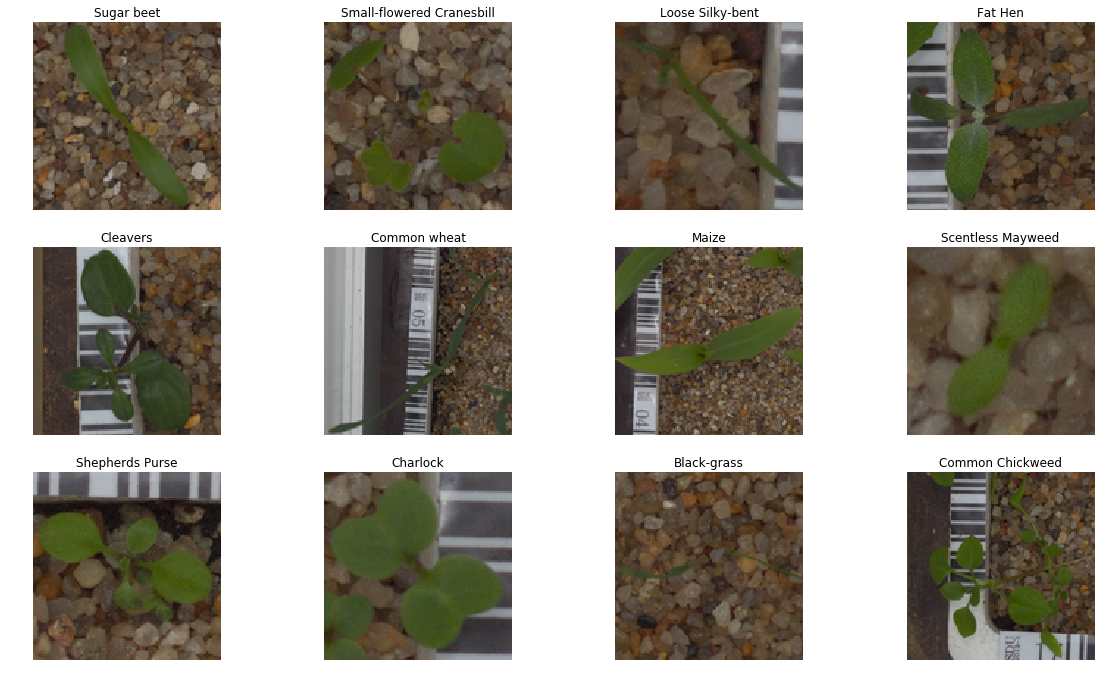

In [9]:
counts = pd.Series()
train = pd.DataFrame()

paths = list()
for label in labels:
    table = pd.DataFrame()
    train_images_path = glob.glob("Plant Seedlings Classification/train/{0}/*.png".format(label))
    label_list = [label for i in range(len(train_images_path))]
    image_to_display = random.randint(0, len(train_images_path))
    paths.append(train_images_path[image_to_display])
    counts[label] = len(train_images_path)
    table["image_path"] = train_images_path
    table["label"] = label_list
    train = pd.concat([train, table])

grid = int(np.sqrt(len(paths))) + 1
for i, (path, label) in enumerate(zip(paths, labels)):
    plt.subplot(grid+1, grid, i+1)
    image = PIL.Image.open(path)
    image = ImageOps.fit(image, resize_shape, PIL.Image.ANTIALIAS).convert('RGB')
    plt.title(label)
    plt.imshow(image)
    plt.axis('off')
    

/home/poiroot/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


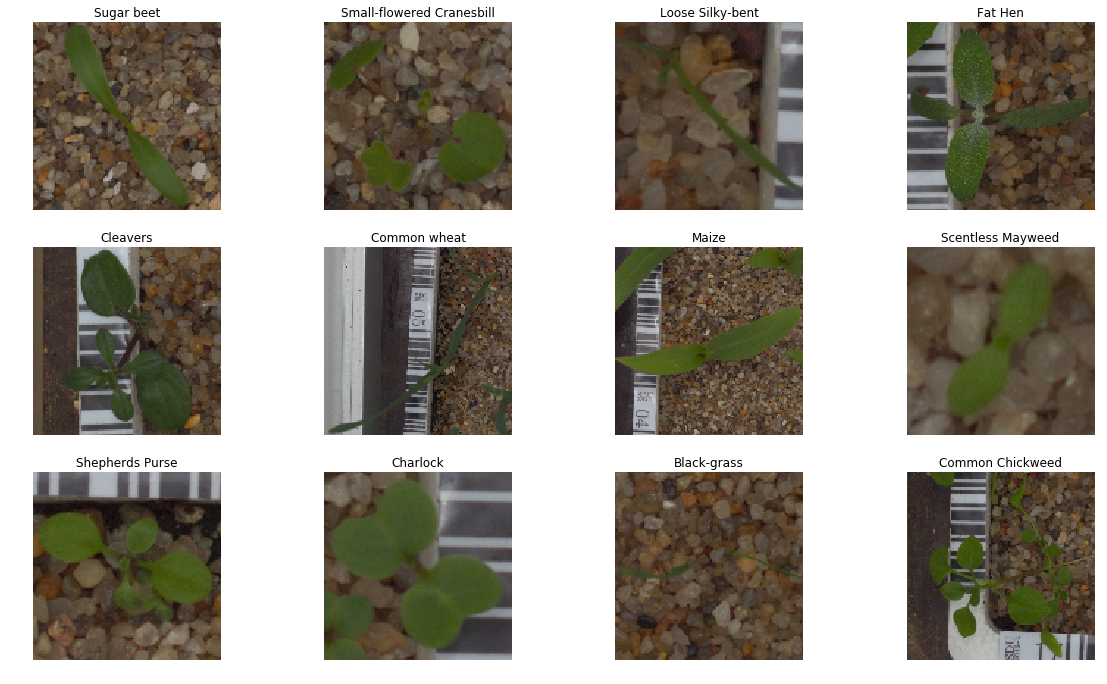

In [10]:
grid = int(np.sqrt(len(paths))) + 1
for i, (path, label) in enumerate(zip(paths, labels)):
    plt.subplot(grid+1, grid, i+1)
    image = resize(imageio.imread(path), output_shape=resize_shape, mode="reflect")
    plt.title(label)
    plt.imshow(image)
    plt.axis('off')

In [12]:
A = pd.DataFrame(counts, columns=["counts"])
A["ratio"] = A["counts"] / sum(counts)
display(A)
del A

,counts,ratio
Sugar beet,385,0.081053
Small-flowered Cranesbill,496,0.104421
Loose Silky-bent,654,0.137684
Fat Hen,475,0.100000
Cleavers,287,0.060421
Common wheat,221,0.046526
Maize,221,0.046526
Scentless Mayweed,516,0.108632
Shepherds Purse,231,0.048632
Charlock,390,0.082105


## Create train and test dataset

In [13]:
# one hot encoding
def oneHotEncoding(label, l):
    if label is np.nan:
        return np.nan
    if l == label:
        return 1
    return 0
for label in labels:
    train["{0}".format(label)] = train["label"].apply(oneHotEncoding, args=(label,))

In [14]:
X_train = list()
y_train = list()
X_val = list()
y_val = list()
num_val_sample = 10
num_train_sample = 1000
length = len(set(train["label"]))
last_percent_reported = None
for i, label in enumerate(set(train["label"])):
    """
    Reports every 5% change in split dataset progress.
    """
    percent = int(i * 100 / length)
    if last_percent_reported != percent:
        if percent % 5 == 0:
          sys.stdout.write("%s%%" % percent)
          sys.stdout.flush()
        else:
          sys.stdout.write(".")
          sys.stdout.flush()
    last_percent_reported = percent
    
    random.seed(seed)
    table = train[train["label"] == label]
    try:
        validation_index = random.sample(range(len(table.index)), num_val_sample)
        train_index = list(range(len(table.index)))
    except ValueError: # random.sample Sample larger than population
        validation_index = list(range(len(table.index)))
        train_index = list()
    # Validation set
    for index in validation_index:
        if len(train_index) != 0:
            train_index.remove(index)
        row = table.loc[table.index[index]]
        image = PIL.Image.open(row["image_path"])
        image = np.array(ImageOps.fit(image, resize_shape, PIL.Image.ANTIALIAS).convert('RGB'))
        X_val.append(image)
        #y_val.append(list(row[table.columns[-num_labels:]]))
        y_val.append(label)
    # Train set
    try:
        train_index = random.sample(range(len(table.index)), num_train_sample)
    except ValueError: # random.sample Sample larger than population
        pass
    for index in train_index:
        row = table.loc[table.index[index]]
        image = PIL.Image.open(row["image_path"])
        image = np.array(ImageOps.fit(image, resize_shape, PIL.Image.ANTIALIAS).convert('RGB'))
        X_train.append(image)
        #y_train.append(list(row[table.columns[-num_labels:]]))
        y_train.append(label)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
print("\nTrain image size: ", X_train.shape)
print("Train target size", y_train.shape)
print("Validation image size: ", X_val.shape)
print("Validation target size: ", y_val.shape)

0%..25%..50%..75%..
Train image size:  (4630, 128, 128, 3)
Train target size (4630,)
Validation image size:  (120, 128, 128, 3)
Validation target size:  (120,)


## Save train and validation set

In [16]:
# pickle_file = 'train_val10_{1}*{1}_seed{0}.pickle'.format(seed, resize_shape[0])

# try:
#     f = open(pickle_file, 'wb')
#     save = {
#     'train_dataset': X_train,
#     'train_labels': y_train,
#     'valid_dataset': X_val,
#     'valid_labels': y_val,
#     }
#     pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#     f.close()
# except Exception as e:
#     print('Unable to save data to', pickle_file, ':', e)
#     raise
# statinfo = os.stat(pickle_file)
# print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 233947421


## Load train and validation set

In [3]:
pickle_file = 'train_val10_{1}*{1}_seed{0}.pickle'.format(seed, resize_shape[0])

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    train_dataset = train_dataset.astype("float32")
    valid_dataset = valid_dataset.astype("float32")
    train_dataset /= 255
    valid_dataset /= 255
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)

Training set (4630, 256, 256, 3) (4630, 12)
Validation set (120, 256, 256, 3) (120, 12)
